In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import re

### import data

In [2]:
def standardization(df) :
    scaler = StandardScaler()
    x  = df.T.to_numpy()
    X = scaler.fit_transform(x)
    stand_df = pd.DataFrame(X.T,index=df.index,columns=df.columns)
    return stand_df

In [3]:
lihc_df = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/lihc_protein_coding_gene_std_exp_profile_tumor_only.txt',sep = '\t',index_col = 0)

hbv_conversion_table = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/' + 'hbv_gene_conversion_table.txt',sep = '\t',index_col=0)
ens_id = hbv_conversion_table['Ensembl_ID'].values  
non_protein_coding = ['ENSG00000211896', 'ENSG00000211677', 'ENSG00000211751', 'ENSG00000227191']
idx = [bool(x in non_protein_coding) ==False for x in ens_id]
ens_id = ens_id[idx]

sample_df = pd.DataFrame({'Sample' : [x.split('.')[0] for x in lihc_df.columns],'Label' : ['Tumor'] * lihc_df.shape[1]})
idx = [bool(re.search('\.',x)) for x in lihc_df.columns]
sample_df.loc[idx,"Label"] = 'Normal'

In [11]:
idx = [x.split('-')[-1] for x in clinical_info['bcr_patient_barcode']]

In [4]:
clinical_info_file = '/home/bruce1996/data/LIHC_anomaly_detection/data/sample_info/nationwidechildrens.org_clinical_patient_lihc.txt'
clinical_info = pd.read_csv(clinical_info_file,sep='\t')
clinical_info = clinical_info.drop([0,1],axis=0)
idx = [x.split('-')[-1] for x in clinical_info['bcr_patient_barcode']]
clinical_info.index = idx

idx = [bool(re.search('Hepatitis B Surface Antigen' ,x )) for x in clinical_info.loc[:,'viral_hepatitis_serology'].values]
hbv_positive = clinical_info.loc[idx,'viral_hepatitis_serology'].index
tmp = []
for x in sample_df['Sample'] :
    if x in hbv_positive :
        tmp.append('Positive')
    else :
        tmp.append('Negative')
sample_df['HBV'] = tmp
hbv_idx = sample_df[sample_df['HBV'] == 'Positive'].index

In [48]:
file = "/home/bruce1996/data/LIHC_anomaly_detection/differential_expression/lihc_nonhbv_only_deseq_metadata.txt"
exp_profile = pd.read_csv(file,sep='\t',index_col=0)
exp_profile.index = [str(x) for x in exp_profile.index]
exp_profile.to_csv(file,sep='\t')

### Data augmentation

In [6]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [80]:
lihc_candidate = lihc_df.loc[ens_id,:]

In [74]:
def plot_pc_explain_ratio(exp_matrix,output_path,explained_ratio_threshold=0.8) :
    '''
    exp_matrix : numpy array; row is gene column is sample
    explained_ratio : float; threshold of sum of principle component explained ratio 
    '''
    sum_variance = [] 
    for i in range(2,100) :
        pca = PCA(n_components=i)
        exp_pca = pca.fit_transform(exp_matrix)
        explained_ratio = sum(pca.explained_variance_ratio_)
        sum_variance.append(explained_ratio)
        if explained_ratio > explained_ratio_threshold :
            break
        
    df = pd.DataFrame({'Explained variance' : sum_variance + list(np.repeat(explained_ratio_threshold,len(sum_variance))),
                       'X' : np.concatenate([np.arange(len(sum_variance)),np.arange(len(sum_variance))]),
                       'Label' : (['Explained variance']* len(sum_variance) + ['Threshold']*len(sum_variance)) })
    
    plt.figure(figsize=(10,6))
    sns.lineplot(data = df ,x = 'X',y='Explained variance',hue = 'Label',style = 'Label',marker = True)
    plt.text(len(sum_variance)-1,explained_ratio_threshold,"(%d,%0.3f)" %(len(sum_variance),sum_variance[-1]) )
    plt.grid()
    plt.xlabel("Number of principle component")
    plt.title('Explained variance ratio in different number of principle component')
    plt.savefig(output_path,dpi = 300,bbox_inches = 'tight')
    return len(sum_variance)
    

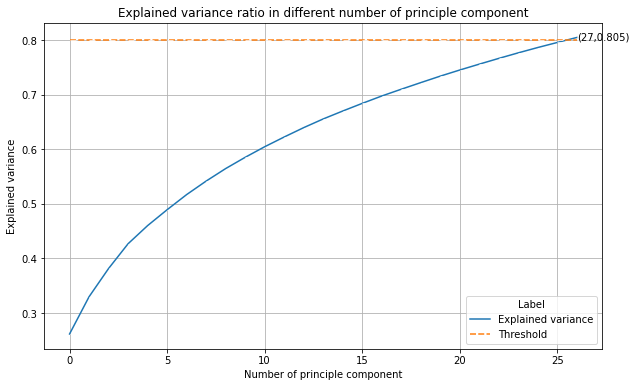

In [82]:
n_pc = plot_pc_explain_ratio(lihc_candidate,'test.png')

Text(0, 0.5, 'PC2 (12.58%)')

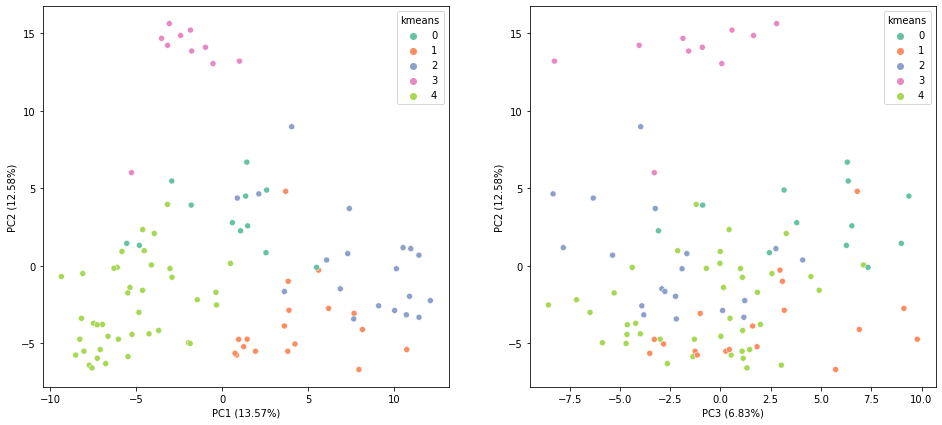

In [35]:
n_pc = 27
X = lihc_candidate
pca = PCA(n_components=n_pc)
hbv_pca = pca.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
pca_df = pd.DataFrame({'PC1' : hbv_pca[:,0],'PC2' : hbv_pca[:,1],'PC3' : hbv_pca[:,2]})
pca_df.loc[:,'kmeans'] = kmeans.labels_

fig,axs = plt.subplots(1,2,figsize = (16,7))
sns.scatterplot(data = pca_df,x = 'PC1',y = 'PC2',hue = 'kmeans',palette='Set2',ax=axs[0])
axs[0].set_xlabel("PC1 (" + str(round(100*pca.explained_variance_ratio_[0],2)) + '%)')
axs[0].set_ylabel("PC2 (" + str(round(100*pca.explained_variance_ratio_[1],2)) + '%)')

sns.scatterplot(data = pca_df,x = 'PC3',y = 'PC2',hue = 'kmeans',palette='Set2',ax=axs[1])
axs[1].set_xlabel("PC3 (" + str(round(100*pca.explained_variance_ratio_[2],2)) + '%)')
axs[1].set_ylabel("PC2 (" + str(round(100*pca.explained_variance_ratio_[1],2)) + '%)')

In [13]:
def kmeans_base_data_augmentation(X,n_pc,n_cluster,top_n_cluster,n_sample_synthesized) :

    if n_pc == 0 :
        pca_r = X
    else :
        pca = PCA(n_components=n_pc)
        pca_r = pca.fit_transform(X)

    n_sample = X.shape[0]
    centroid = np.sum(pca_r,axis=0) / n_sample
    
    kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(pca_r)
    cluster_centroid = np.zeros([n_cluster,n_pc])
    distance = np.zeros(n_cluster)
    for i in range(n_cluster) :
        c_idx = kmeans.labels_ == i
        cluster_centroid[i] = np.sum(pca_r[c_idx,:],axis=0) / sum(c_idx)
        distance[i] = np.linalg.norm(centroid - cluster_centroid[i])
    
    d_idx = np.argsort(distance)[::-1]
    cluster = np.arange(n_cluster)[d_idx]
    #only n cluster data be selected as reference
    selected_cluster = list(cluster[:top_n_cluster])
    idx = [x in selected_cluster for x in kmeans.labels_]
    synthetic_x = pca_r[idx,:]
    
    synthetic_data = np.zeros([n_sample_synthesized,n_pc])
    n = 0 
    n_sample_per_cluster = round(n_sample_synthesized / top_n_cluster)
    n_of_cluster = np.repeat(n_sample_per_cluster,top_n_cluster)

    if sum(n_of_cluster) > n_sample_synthesized :
        n_of_cluster[-1] -= (sum(n_of_cluster) - n_sample_synthesized)

    for c_idx,c in enumerate(selected_cluster) :
        synthetic_x = pca_r[kmeans.labels_ == c, :]
        for i in range(n_of_cluster[c_idx]) :
            choice = np.random.choice(np.arange(synthetic_x.shape[0]),2)
            r1 = synthetic_x[choice[0],:]
            r2 = synthetic_x[choice[1],:]
            synthetic_data[n,:] = (r1 + r2) / 2
            n += 1

    synthetic_data = pca.inverse_transform(synthetic_data)
    
    return synthetic_data

In [14]:
def gmm_base_data_augmentation(X,n_pc,n_cluster,top_n_cluster,n_sample_synthesized) :

    if n_pc == 0 :
        pca_r = X
    else :
        pca = PCA(n_components=n_pc)
        pca_r = pca.fit_transform(X)

    n_sample = X.shape[0]
    centroid = np.sum(pca_r,axis=0) / n_sample
    
    gm = GaussianMixture(n_components=n_cluster,covariance_type = 'spherical').fit(pca_r)
    gm_label = gm.fit_predict(pca_r)
    cluster_centroid = np.zeros([n_cluster,n_pc])
    distance = np.zeros(n_cluster)
    for i in range(n_cluster) :
        c_idx = sum(gm_label == i)
        if c_idx == 0 :
            pass
        cluster_centroid[i] = np.sum(pca_r[c_idx,:],axis=0) / c_idx
        distance[i] = np.linalg.norm(centroid - cluster_centroid[i])
    
    d_idx = np.argsort(distance)[::-1]
    cluster = np.arange(n_cluster)[d_idx]
    #only n cluster data be selected as reference
    selected_cluster = list(cluster[:top_n_cluster])
    idx = [x in selected_cluster for x in gm_label]
    synthetic_x = pca_r[idx,:]
    
    synthetic_data = np.zeros([n_sample_synthesized,n_pc])
    n = 0 
    n_sample_s_per_cluster = round(n_sample_synthesized / top_n_cluster)
    '''
    sample_per_cluster = np.zeros(len(selected_cluster),dtype = int)
    for i in range(len(selected_cluster)) :
        ratio = sum(gm_label == selected_cluster[i]) / n_sample
        sample_per_cluster[i] = round(ratio * (n_sample_synthesized / n_sample))
    #make sure number of synthetic data equal to n_sample_synthesized
    if sum(sample_per_cluster) != n_sample_synthesized :
        sample_per_cluster[-1] += (n_sample_synthesized - sum(sample_per_cluster))
    '''

    for c in enumerate(selected_cluster) :
        synthetic_x = pca_r[gm_label == c, :]
        for i in range(n_sample_s_per_cluster) :
            choice = np.random.choice(np.arange(synthetic_x.shape[0]),2)
            r1 = synthetic_x[choice[0],:]
            r2 = synthetic_x[choice[1],:]
            synthetic_data[n,:] = (r1 + r2) / 2
            n += 1

    synthetic_data = pca.inverse_transform(synthetic_data)
    
    return synthetic_data

In [54]:
def centroid_base_data_augmentation(X,n_pc,n_sample_synthesized) :
    '''
    X : numpy array(n_sample,n_feature),contain origin data information
    n_pc : integer, number of principle component 
    '''

    if n_pc == 0 :
        pca_r = X
    else :
        pca = PCA(n_components=n_pc)
        pca_r = pca.fit_transform(X)
    
    n_sample = X.shape[0]
    centroid = np.sum(pca_r,axis=0) / n_sample
    distance = np.zeros(n_sample)
    '''
    p = 1 / n_sample
    p_lower = p * min(p_interval*10)/5
    p_upper = p * max(p_interval*10)/5
    p_each = (p_upper - p_lower) / (n_sample -1)
    for i in range(103) :
        sample_p[i] = p_lower + p_each * i
    '''
    #caculate probability weight for each sample
    sample_p = np.zeros(n_sample)
    #calculate distance to centroid for each data point
    for i in range(X.shape[0]) :
        distance[i] = np.linalg.norm(centroid - pca_r[i,:])
        #the closer to the centroid,the lower the probability
        sample_p[i] = i+1 / sum(np.arange(1,n_sample+1))

    synthetic_data = np.zeros([n_sample_synthesized,n_pc])
    sample_p = list(sample_p)
    
    for i in range(n_sample_synthesized) :
        choice = np.random.choice(np.argsort(distance),2,sample_p)
        r1 = pca_r[choice[0],:]
        r2 = pca_r[choice[1],:]
        synthetic_data[i,:] = (r1 + r2) / 2
    synthetic_data = pca.inverse_transform(synthetic_data)
    return synthetic_data

In [52]:
def data_augmentatation_pca_scatterplot(origin_m,synthetic_m,fig_output_path) :
    
    x = np.concatenate([origin_m,synthetic_m],axis=0)
    pca = PCA(n_components=3)
    syn_pca = pca.fit_transform(x)
    pca_df = pd.DataFrame({'PC1' : syn_pca[:,0],'PC2' : syn_pca[:,1],'PC3' : syn_pca[:,2],
                           'Label' : ['Origin'] *origin_m.shape[0] + ['Syntheitc'] * synthetic_m.shape[0]})

    fig,axs = plt.subplots(1,2,figsize = (16,7))
    sns.scatterplot(data = pca_df,x = 'PC1',y = 'PC2',hue = 'Label',palette='Set2',ax = axs[0])
    sns.scatterplot(data = pca_df,x = 'PC3',y = 'PC2',hue = 'Label',palette='Set2',ax=axs[1])

    axs[0].set_xlabel("PC1 (" + str(round(100*pca.explained_variance_ratio_[0],2)) + '%)')
    axs[0].set_ylabel("PC2 (" + str(round(100*pca.explained_variance_ratio_[1],2)) + '%)')
    axs[1].set_xlabel("PC3 (" + str(round(100*pca.explained_variance_ratio_[2],2)) + '%)')
    axs[1].set_ylabel("PC2 (" + str(round(100*pca.explained_variance_ratio_[1],2)) + '%)')
    plt.savefig(fig_output_path,dpi = 300,bbox_inches = 'tight')

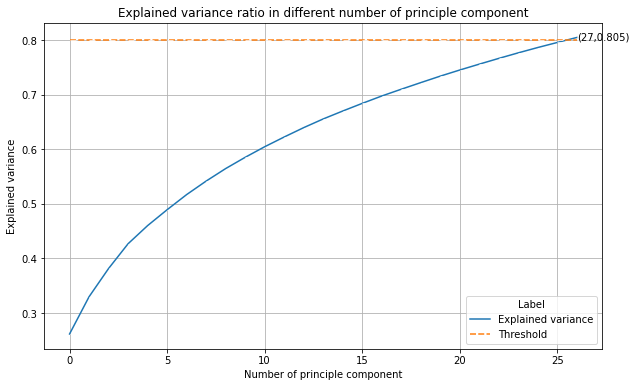

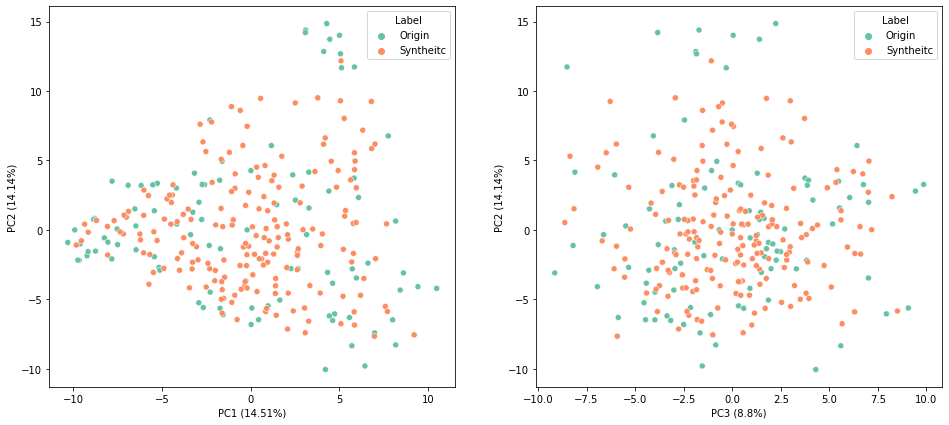

In [59]:
X = lihc_candidate
n_pc = plot_pc_explain_ratio(X,'test.png')
synthetic_X = centroid_base_data_augmentation(X,n_pc,198)
data_augmentatation_pca_scatterplot(X,synthetic_X)

In [44]:
syn_idx = ['Synthetic' + str(x) for x in range(synthetic_X.shape[0]) ]
syn_df = pd.DataFrame(synthetic_X,index=syn_idx,columns=lihc_df.columns)
syn_df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/centroid_based_synthetic.txt",sep = '\t')